### Import required libraries

In [19]:

import pymysql
from cryptography.fernet import Fernet
import json
from collections import namedtuple
import time
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine 
from sklearn import model_selection
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

%matplotlib inline

### Increase the size of the screen

In [20]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

OptionError: "No such keys(s): 'display.height'"

### Decrypt Credentials and Connect to Database

In [21]:
#Uncode the secret license file
def unencrypt():
    try:
        key = b'IXx5rHfP15FqP4ahx2pwcud-XmcBzU553Ri6p-nVhnc=' #Fernet.generate_key()
        cipher_suite = Fernet(key)
        with open('/usr/local/etc/musicmood_bytes.bin', 'rb') as file_object:
            for line in file_object:
                encryptedpwd = line
        uncipher_text = (cipher_suite.decrypt(encryptedpwd))
        plain_text_encryptedpassword = bytes(uncipher_text).decode("utf-8") #convert to string
        x = json.loads(plain_text_encryptedpassword, object_hook=lambda d: namedtuple('X', d.keys())(*d.values()))
        return x
    except Exception as e:
        print(str(e))
        return "Error" 

#Setup the database connection
credentials = unencrypt()
user_id = credentials.user
user_password = credentials.password
dbname = credentials.dbname
server = credentials.server
conn = pymysql.connect(server,user_id,user_password,dbname)

### Load the clean dataset

In [22]:
start_time = time.time()
df = pd.read_sql('SELECT * FROM songs_instances_data', con = conn)
print('--- %s seconds ---' % (time.time() - start_time))
    
df.drop(['index'],axis=1, inplace=True)
df.head(15)

df.describe()
#print(df.columns)

--- 1.4596867561340332 seconds ---


,bill_popularity,weeks_ranked,highest_rank,lowest_rank,weeks_top_spot,weeks_top_10,weeks_top_20,weeks_top_30,weeks_top_40,weeks_top_50,...,gnr_Metal,gnr_Pop,gnr_Pop Standards,gnr_Punk,gnr_Rap Hip Hop,gnr_Rhythm and Blues,gnr_Rock,gnr_Rock and Roll,gnr_Ska Reggae Dancehall,is_top40
count,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,...,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000
mean,461.917585,8.590371,24.106161,57.427989,0.112444,1.080294,2.104774,3.076295,3.985149,4.848960,...,0.067156,0.137087,0.019502,0.002285,0.045777,0.049857,0.368666,0.031089,0.002856,0.379111
std,646.707813,9.515133,29.813271,43.503135,1.002081,3.229548,4.882840,6.084759,7.014856,7.747965,...,0.250303,0.343953,0.138288,0.047747,0.209010,0.217659,0.482463,0.173566,0.053367,0.485185
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,167.000000,7.000000,9.000000,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,799.000000,15.000000,44.000000,95.000000,0.000000,0.000000,1.000000,5.000000,7.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,9009.000000,104.000000,100.000000,100.000000,84.000000,88.000000,95.000000,96.000000,104.000000,104.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Visualize only important features 

In [23]:
songs = df [['duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', 'words_song_u', 'words_song', \
             'words_song_r', 'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 'speed_general', \
             'artist_familiarity', 'artist_hotttnesss', 'gnr_Blues', 'gnr_Country', 'gnr_Folk', 'gnr_Funk', \
             'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', 'gnr_Pop', 'gnr_Pop Standards', \
             'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', 'gnr_Rock and Roll', \
             'gnr_Ska Reggae Dancehall', 'is_top40']]
songs.shape

(12255, 33)

# Hyper-Parameter Tuning Template

### Instructions

The objective of this notebook is to be used as a template to aid in the shared process within the team to obtain the best performance hyper-parameters for the long list of algorithm that we are testing in our project.
The next cells are going to explain what should be accomplish with each of the algorithms assigned.

### Split-Out validation dataset

This step divide our dataset in a ramdom 80/20 train/validation set

In [24]:
array = songs.values
X = array[:,0:-1]
Y = array[:,-1] #is_top40
    
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = \
model_selection.train_test_split(X, Y,test_size=validation_size,stratify = Y, random_state=seed)


  ### Test options and evaluation metric

We are going to test the accuracy metric of different the algorithms truing to increase it as high as possible by trying different combinations of hyper-parameters values.

In [25]:
seed = 7
scoring = 'accuracy'

This next cell import the libraries corresponding to all the algorithms that are going to be tested 

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsClassifier

from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

from sklearn.ensemble import AdaBoostClassifier

### 1. Select one of the algorithms and show its hyper parameters

In this example we are going to show the parameters for the KNeighborsClassifier algorithm

In [27]:
LogisticRegression().get_params(deep = True)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### 2. Read

As we don't know so well how this algorithms are conceived and whatthis hyper-parameters mean we should use the help method.

In [28]:
help(LinearDiscriminantAnalysis)

Help on class LinearDiscriminantAnalysis in module sklearn.discriminant_analysis:

class LinearDiscriminantAnalysis(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.base.TransformerMixin)
 |  Linear Discriminant Analysis
 |  
 |  A classifier with a linear decision boundary, generated by fitting class
 |  conditional densities to the data and using Bayes' rule.
 |  
 |  The model fits a Gaussian density to each class, assuming that all classes
 |  share the same covariance matrix.
 |  
 |  The fitted model can also be used to reduce the dimensionality of the input
 |  by projecting it to the most discriminative directions.
 |  
 |  .. versionadded:: 0.17
 |     *LinearDiscriminantAnalysis*.
 |  
 |  Read more in the :ref:`User Guide <lda_qda>`.
 |  
 |  Parameters
 |  ----------
 |  solver : string, optional
 |      Solver to use, possible values:
 |        - 'svd': Singular value decomposition (default).
 |          Does not compute the covariance m

### 3. Hyper-Parameter Tuning with GridSearchCV

One of the best ways to find a suitable bet performing set of hyper-parameters for a classifier algorithm is by using GridSearchCV. What you have to do is complete the structure <b>tuned_parameters</b> with possible combinations of values and then run. The process will get you the best combination of parameters for the data. We recommend iterate this process at least 3 times per algorithm changing values. 

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# {'C': 1.0,
#  'class_weight': None,
#  'dual': False,
#  'fit_intercept': True,
#  'intercept_scaling': 1,
#  'max_iter': 100,
#  'multi_class': 'ovr',
#  'n_jobs': 1,
#  'penalty': 'l2',
#  'random_state': None,
#  'solver': 'liblinear',
#  'tol': 0.0001,
#  'verbose': 0,
#  'warm_start': False}


LinearDiscriminantAnalysis().get_params(deep = True)
tuned_parameters = [{
                        'C': [0.99, 1.0, 1.1], 
                        'class_weight': ['balanced'], 
                        'dual': [False],
                        'fit_intercept': [True],
                        'max_iter': [90, 100, 110],
                        'multi_class': ['ovr'],
                        'n_jobs': [1],
                        'penalty': ['l2'],
                        'random_state': [2],
                        'solver': ['liblinear'],
                        'tol': [0.0001],
                        'verbose': [0,1],
                        'warm_start': [True, False]
                     },
    {
                        'C': [0.99, 1.0, 1.1], 
                        'class_weight': ['balanced'], 
                        'dual': [False],
                        'fit_intercept': [True],
                        'max_iter': [90, 100, 110],
                        'multi_class': ['ovr' ],
                        'n_jobs': [1],
                        'penalty': ['l1', 'l2'],
                        'random_state': [2],
                        'solver': ['liblinear'],
                        'tol': [0.0001],
                        'verbose': [0,1],
                        'warm_start': [True, False]
                     },
                     {
                        'C': [0.70, 0.80, 0.90], 
                        'class_weight': ['balanced'], 
                        'dual': [False],
                        'fit_intercept': [True],
                        'max_iter': [60, 70, 80],
                        'multi_class': ['ovr'],
                        'n_jobs': [1],
                        'penalty': ['l2'],
                        'random_state': [2],
                        'solver': ['liblinear'],
                        'tol': [0.0001],
                        'verbose': [0, 1],
                        'warm_start': [True, False]
                     },
                     {
                        'C': [1.2, 1.3, 1.4], 
                        'class_weight': ['balanced'], 
                        'dual': [False],
                        'fit_intercept': [True],
                        'max_iter': [120, 130, 140],
                        'multi_class': ['ovr'],
                        'n_jobs': [1],
                        'penalty': ['l2'],
                        'random_state': [2],
                        'solver': ['liblinear'],
                        'tol': [0.0001],
                        'verbose': [0, 1],
                        'warm_start': [True, False]
                     }
                    ]

#scores = ['precision', 'recall']
scores = ['accuracy']

for score in scores:
    print("Hyper-parameters (Tunning) for %s" % score)
    print()
    start_time = time.time()
    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, Y_train)

    print()
    print("--- Results ---")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    
print("Classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = Y_validation, clf.predict(X_validation)
print(classification_report(y_true, y_pred))
print()
print('--- %s seconds ---' % (time.time() - start_time))


Hyper-parameters (Tunning) for accuracy

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][L

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/anaconda3/envs/MusicMood/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

### 4. Analyze and Store the best set of parameters for the algorithm

KNeighborsClassifier
0.6417788657690738
[[896 626]
 [252 677]]


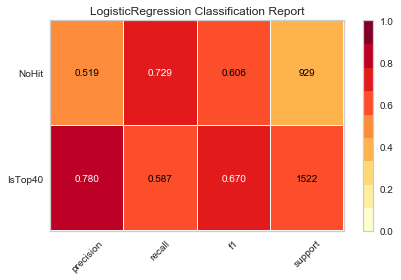

In [33]:
#{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
model = LogisticRegression(C= 1.1, class_weight= 'balanced', dual= False, fit_intercept= True, max_iter= 90, multi_class= 'ovr', n_jobs= 1, penalty= 'l2', random_state= 2, solver= 'liblinear', tol= 0.0001, verbose= 0, warm_start= False)


from yellowbrick.classifier import ClassificationReport
classes = ["IsTop40", "NoHit"]
def plotting(name, model):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print(name)
    print(accuracy_score(Y_validation, predictions))
    print(confusion_matrix(Y_validation, predictions))
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, Y_train)  # Fit the visualizer and the model
    visualizer.score(X_validation, Y_validation)  # Evaluate the model on the test data
    g = visualizer.poof()             # Draw/show/poof the data
    

plotting("LogisticRegression", model)

### 5. Submit via email the set of best parameters for the algorithms you were assigned 

Thank you! :)